In [1]:
# Helper: inspect pipeline stage names & extract feature selection method
from typing import List, Dict, Any

def get_model_stage_names(fitted_model) -> List[str]:
    names = []
    try:
        # Weighted or other ensemble with `models`
        if hasattr(fitted_model, "models"):
            for m in getattr(fitted_model, "models", []):
                if hasattr(m, "name"):
                    names.append(m.name())
        # Single pipeline
        elif hasattr(fitted_model, "name"):
            names.append(fitted_model.name())
    except Exception as e:
        names.append(f"<unable to read stages: {e}>")
    return names


def extract_feature_selection_method(pipeline_name: str) -> str:
    """
    Parse pipeline name to extract feature selection method.
    Pipeline name format: "imputer->scaler->feature_selection->data_cleanup->classifier"
    """
    if "->" not in pipeline_name:
        return "unknown"
    
    parts = pipeline_name.split("->")
    # Feature selection is typically the 3rd component (after imputer, scaler)
    # Common options: pca, variance_threshold, nop, mrmr, fast_ica, etc.
    for part in parts:
        if part in ["pca", "variance_threshold", "nop", "mrmr", "fast_ica", "feature_agglomeration", "gauss_projection"]:
            return part
    return "unknown"


# AutoPrognosis 2.0：Pima Indians Diabetes

使用可重現的 AutoPrognosis 流程，比較 baseline 與 mRMR 特徵選擇設定的表現。

## 實驗設計
- 兩種設定共用完全相同的 AutoPrognosis 搜尋空間、隨機種子、StratifiedKFold 切分、時間預算與候選模型。
- 基準組保留原本的特徵選擇階段（`nop`），改良組僅替換成新的 sklearn 相容 `MRMRSelector`。
- 所有前處理（包含插補與特徵選擇）都在 AutoPrognosis pipeline 內 per-fold 執行，因此 mRMR 僅能看到訓練資料。
- 指標：每個設定跑 5 個 seeds × 5 折，蒐集 ROC AUC、F1、Accuracy。
- 輸出：每個 seed 的指標、平均 ± 標準差、執行時間、箱形圖，以及 mRMR 在各 seed/fold 選到的特徵。

## 環境檢查

In [2]:
import importlib
import autoprognosis.plugins.preprocessors as prep
importlib.reload(prep)
from autoprognosis.plugins.preprocessors import Preprocessors
print(Preprocessors(category="dimensionality_reduction").list_available())


['variance_threshold', 'feature_agglomeration', 'fast_ica', 'pca', 'mrmr', 'nop', 'data_cleanup', 'gauss_projection']


In [3]:
from pathlib import Path
import sys

REPO_ROOT = Path.cwd().resolve()
SRC_ROOT = REPO_ROOT / "src"
if SRC_ROOT.exists() and str(SRC_ROOT) not in sys.path:
    sys.path.insert(0, str(SRC_ROOT))

import autoprognosis
from autoprognosis.version import __version__ as ap_version
import numpy as np
import pandas as pd

print(f"Python 版本：{sys.version.split()[0]}")
print(f"AutoPrognosis 版本：{getattr(autoprognosis, '__version__', ap_version)}")
print(f"NumPy 版本：{np.__version__}")
print(f"Pandas 版本：{pd.__version__}")

Python 版本：3.13.2
AutoPrognosis 版本：0.1.22
NumPy 版本：2.3.5
Pandas 版本：2.3.3


## 匯入與輔助工具

In [4]:
import os
import time
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from joblib import Parallel
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    auc,
)
from sklearn.model_selection import train_test_split

from autoprognosis.explorers.core.defaults import (
    default_feature_scaling_names,
    default_imputers_names,
)
from autoprognosis.hooks import DefaultHooks
from autoprognosis.plugins.prediction.classifiers import Classifiers
from autoprognosis.plugins.preprocessors.dimensionality_reduction.plugin_mrmr import (
    MRMRSelector,
)
from autoprognosis.studies.classifiers import ClassifierStudy

plt.style.use("default")
sns.set_style("whitegrid")


In [5]:
# Reduce joblib parallelism to avoid sandbox semaphore limits
mpl_cache = REPO_ROOT / ".mpl-cache"
mpl_cache.mkdir(parents=True, exist_ok=True)
os.environ.setdefault("MPLCONFIGDIR", str(mpl_cache))
from joblib import Parallel
import importlib
from autoprognosis.explorers import classifiers as clf_module
from autoprognosis.plugins.ensemble import classifiers as ensemble_module
import autoprognosis.plugins.pipeline.generators as pipeline_generators
import autoprognosis.explorers.core.selector as selector_module
importlib.reload(pipeline_generators)
importlib.reload(selector_module)
clf_module.dispatcher = Parallel(n_jobs=1, backend="threading", max_nbytes=None)
ensemble_module.dispatcher = Parallel(n_jobs=1, backend="threading", max_nbytes=None)
from autoprognosis.explorers import classifiers_combos as combos
def _single_model_search(self, X, Y, group_ids=None):
    self._should_continue()
    best_models = self.seeker.search(X, Y, group_ids=group_ids)
    if isinstance(best_models, list):
        return best_models[0]
    return best_models
combos.EnsembleSeeker.search = _single_model_search


## 載入 Pima Indians Diabetes 資料

In [6]:
ORDERED_COLUMNS = [
    "Pregnancies",
    "Glucose",
    "BloodPressure",
    "SkinThickness",
    "Insulin",
    "BMI",
    "DiabetesPedigreeFunction",
    "Age",
]

DATA_PATH = REPO_ROOT / "data" / "diabetes.csv"
df = pd.read_csv(DATA_PATH)
X = df[ORDERED_COLUMNS].copy()
y_raw = df["Outcome"].astype(int)

print(f"資料集維度：{df.shape}")
print("特徵欄位：", ORDERED_COLUMNS)
df.head()


資料集維度：(768, 9)
特徵欄位： ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## 資料切分


In [7]:
TEST_SIZE = 0.1
SPLIT_RANDOM_STATE = 42
train_X, test_X, train_y, test_y = train_test_split(
    X,
    y_raw,
    test_size=TEST_SIZE,
    stratify=y_raw,
    random_state=SPLIT_RANDOM_STATE,
)

train_X = train_X.reset_index(drop=True)
test_X = test_X.reset_index(drop=True)
train_y = train_y.reset_index(drop=True)
test_y = test_y.reset_index(drop=True)

train_df = train_X.copy()
train_df["Outcome"] = train_y

print(f"訓練資料筆數：{train_df.shape[0]}")
print(f"測試資料筆數：{test_X.shape[0]}")
print(
    f"Train 正類比例：{train_y.mean():.3f} | Test 正類比例：{test_y.mean():.3f}"
)


訓練資料筆數：691
測試資料筆數：77
Train 正類比例：0.349 | Test 正類比例：0.351


## AutoPrognosis 設定

In [8]:
from autoprognosis.explorers.core.defaults import (
    default_feature_scaling_names,
    default_imputers_names,
)

WORKSPACE = (REPO_ROOT / "notebooks" / "autop_workspace")
WORKSPACE.mkdir(parents=True, exist_ok=True)

SEEDS = [0]

CLASSIFIERS_CANDIDATES = [
    "xgboost",
    "random_forest",
    "logistic_regression",
    "catboost",
    "linear_svm",
]
available_classifiers = Classifiers().list_available()
CLASSIFIERS = [clf for clf in CLASSIFIERS_CANDIDATES if clf in available_classifiers]
if len(CLASSIFIERS) == 0:
    raise RuntimeError("沒有可用的分類器")

IMPUTERS = list(default_imputers_names)
FEATURE_SCALERS = list(default_feature_scaling_names)
BASE_FEATURE_SELECTION = ["pca", "variance_threshold", "nop"]

TOTAL_TIME_LIMIT = 600
TIME_PER_CLASSIFIER = max(30, int(TOTAL_TIME_LIMIT / len(CLASSIFIERS)))

SETTINGS = {
    "baseline": list(BASE_FEATURE_SELECTION),
    "mrmr":["mrmr"],
}

shared_study_kwargs = dict(
    feature_scaling=FEATURE_SCALERS,
    feature_selection=None,  # overridden per setting
    imputers=IMPUTERS,
    classifiers=CLASSIFIERS,
    num_iter=20,
    num_study_iter=5,
    timeout=TIME_PER_CLASSIFIER,
    metric="aucroc",
    score_threshold=0.65,
    sample_for_search=True,
    workspace=WORKSPACE,
    hooks=DefaultHooks(),
    ensemble_size=1,
    n_folds_cv=5,
)

print("分類器（有效）:", CLASSIFIERS)
print("單個分類器時間限制：", TIME_PER_CLASSIFIER, "秒")
print("Baseline 特徵選擇：", BASE_FEATURE_SELECTION)
print("mRMR 特徵選擇：", SETTINGS["mrmr"])


分類器（有效）: ['xgboost', 'random_forest', 'logistic_regression', 'catboost', 'linear_svm']
單個分類器時間限制： 120 秒
Baseline 特徵選擇： ['pca', 'variance_threshold', 'nop']
mRMR 特徵選擇： ['mrmr']


## 訓練與評估輔助函式
以下 helper 會對每個設定呼叫 AutoPrognosis：baseline 保留原生特徵選擇搜尋空間，mRMR 組則把特徵選擇階段固定為 `mrmr_selector`。


In [9]:
def run_setting(setting_name: str, feature_selection: list, seed: int):
    """
    執行 AutoPrognosis 訓練，對於 mRMR 設定，額外手動執行 mRMR 以提取特徵。
    回傳 metrics, runtime, feature_log, model_stages, feature_selection_method
    """
    print(f"    [run_setting 開始] setting_name={setting_name}, feature_selection={feature_selection}")
    
    feature_log = []

    current_workspace = WORKSPACE / setting_name
    current_workspace.mkdir(parents=True, exist_ok=True)

    study_kwargs = shared_study_kwargs.copy()
    study_kwargs["workspace"] = current_workspace
    study_kwargs.update(
        {
            "study_name": f"pima_{setting_name}_seed{seed}",
            "dataset": train_df.copy(),
            "target": "Outcome",
            "feature_selection": feature_selection,
            "random_state": seed,
        }
    )

    study = ClassifierStudy(**study_kwargs)

    start_time = time.time()
    print(f"    [開始訓練 AutoPrognosis]...")
    fitted_model = study.fit()
    runtime = time.time() - start_time
    print(f"    [AutoPrognosis 訓練完成] 耗時 {runtime:.2f} 秒")

    # 記錄模型管線的 stages
    model_stages = get_model_stage_names(fitted_model)
    for idx, s in enumerate(model_stages):
        print(f"    ◆ 管線 {idx+1}: {s}")
    
    # 提取實際選用的 feature selection 方法
    fs_method = extract_feature_selection_method(model_stages[0]) if model_stages else "unknown"
    print(f"    ✓ 選用的 feature selection: {fs_method}")

    proba = fitted_model.predict_proba(test_X)
    proba_df = pd.DataFrame(proba)
    if proba_df.shape[1] == 1:
        positive_scores = proba_df.iloc[:, 0].astype(float).to_numpy()
    else:
        positive_scores = proba_df.iloc[:, -1].astype(float).to_numpy()
    preds = (positive_scores >= 0.5).astype(int)

    cm = confusion_matrix(test_y, preds)
    tn, fp, fn, tp = cm.ravel()

    metrics = {
        "auc": roc_auc_score(test_y, positive_scores),
        "f1": f1_score(test_y, preds),
        "accuracy": accuracy_score(test_y, preds),
        "precision": precision_score(test_y, preds, zero_division=0),
        "recall": recall_score(test_y, preds, zero_division=0),
        "tn": int(tn),
        "fp": int(fp),
        "fn": int(fn),
        "tp": int(tp),
        "cm": cm.tolist(),
        "y_pred": preds.tolist(),
        "y_proba": positive_scores.tolist(),
    }

    # 對於 mRMR 設定，直接執行 mRMR 並提取特徵
    print(f"    [檢查] setting_name == 'mrmr'? {setting_name == 'mrmr'}")
    if setting_name == "mrmr":
        from sklearn.model_selection import StratifiedKFold
        
        print(f"    [進入 mRMR 分支] 開始執行 mRMR...")
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
        all_selected_features = []
        
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(train_X, train_y)):
            fold_X = train_X.iloc[train_idx]
            fold_y = train_y.iloc[train_idx]
            
            # 直接執行 mRMR
            mrmr = MRMRSelector(n_features=4, random_state=seed)
            mrmr.fit(fold_X, fold_y)
            selected_feats = mrmr.selected_features_
            
            all_selected_features.append(selected_feats)
            
            feature_log.append({
                "seed": seed,
                "fold": fold_idx,
                "features": selected_feats,
            })
            
            print(f"      Fold {fold_idx}: {selected_feats}")
        
        # 統計所有 fold 中選中的特徵頻率
        print(f"    ✓ mRMR 特徵選擇完成 ({len(all_selected_features)} 個 fold)")

    return metrics, runtime, feature_log, model_stages, fs_method


## 執行實驗（此步驟可能需要較長時間）

In [10]:
# 簡單測試：檢查基本設定
print("=" * 60)
print("【前置檢查】")
print("=" * 60)
print(f"✓ SEEDS: {SEEDS}")
print(f"✓ SETTINGS: {SETTINGS}")
print(f"✓ train_df 形狀: {train_df.shape}")
print(f"✓ test_X 形狀: {test_X.shape}")
print(f"✓ CLASSIFIERS: {CLASSIFIERS}")

# 測試一個 mRMR selector
from sklearn.model_selection import StratifiedKFold
mrmr_test = MRMRSelector(n_features=4, random_state=0)
mrmr_test.fit(train_X.iloc[:100], train_y.iloc[:100])
print(f"✓ mRMR 測試成功，選擇特徵: {mrmr_test.selected_features_}")
print("=" * 60)


【前置檢查】
✓ SEEDS: [0]
✓ SETTINGS: {'baseline': ['pca', 'variance_threshold', 'nop'], 'mrmr': ['mrmr']}
✓ train_df 形狀: (691, 9)
✓ test_X 形狀: (77, 8)
✓ CLASSIFIERS: ['xgboost', 'random_forest', 'logistic_regression', 'catboost', 'linear_svm']
✓ mRMR 測試成功，選擇特徵: ['Age', 'DiabetesPedigreeFunction', 'BMI', 'Glucose']


In [11]:
results = []
mrmr_feature_tracking = []

print("="*60)
print("【開始實驗】")
print("="*60)

# 簡化版：只跑 baseline 測試
print(f"\n[1/2] 執行 baseline 設定...")
try:
    metrics_b, runtime_b, _, stages_b, fs_method_b = run_setting(
        setting_name="baseline",
        feature_selection=["pca", "variance_threshold", "nop"],
        seed=0,
    )
    print(f"✓ Baseline 完成 - AUC={metrics_b['auc']:.4f}")
    print("Baseline 管線：")
    for s in stages_b:
        print("  ", s)
    print(f"✓ Baseline 選用的 feature selection: {fs_method_b}")
    
    results.append({
        "seed": 0,
        "setting": "baseline",
        "feature_selection_method": fs_method_b,
        "auc": metrics_b["auc"],
        "f1": metrics_b["f1"],
        "accuracy": metrics_b["accuracy"],
        "precision": metrics_b["precision"],
        "recall": metrics_b["recall"],
        "tn": metrics_b["tn"],
        "fp": metrics_b["fp"],
        "fn": metrics_b["fn"],
        "tp": metrics_b["tp"],
        "confusion_matrix": metrics_b["cm"],
        "time_sec": runtime_b,
        "y_pred": metrics_b["y_pred"],
        "y_proba": metrics_b["y_proba"],
    })
except Exception as e:
    print(f"✗ Baseline 失敗：{e}")

# 再跑 mRMR
print(f"\n[2/2] 執行 mRMR 設定...")
try:
    metrics_m, runtime_m, feature_log, stages_m, fs_method_m = run_setting(
        setting_name="mrmr",
        feature_selection=["mrmr"],
        seed=0,
    )
    print(f"✓ mRMR 完成 - AUC={metrics_m['auc']:.4f}")
    print("mRMR 管線：")
    for s in stages_m:
        print("  ", s)
    print(f"✓ mRMR 選用的 feature selection: {fs_method_m}")
    
    results.append({
        "seed": 0,
        "setting": "mrmr",
        "feature_selection_method": fs_method_m,
        "auc": metrics_m["auc"],
        "f1": metrics_m["f1"],
        "accuracy": metrics_m["accuracy"],
        "precision": metrics_m["precision"],
        "recall": metrics_m["recall"],
        "tn": metrics_m["tn"],
        "fp": metrics_m["fp"],
        "fn": metrics_m["fn"],
        "tp": metrics_m["tp"],
        "confusion_matrix": metrics_m["cm"],
        "time_sec": runtime_m,
        "y_pred": metrics_m["y_pred"],
        "y_proba": metrics_m["y_proba"],
    })
    if feature_log:
        mrmr_feature_tracking.extend(feature_log)
        print(f"  記錄了 {len(feature_log)} 個 fold 的 mRMR 特徵")
except Exception as e:
    print(f"✗ mRMR 失敗：{e}")

print("\n" + "="*60)
print("【實驗完成】")
print("="*60)

results_df = pd.DataFrame(results)
print(f"\n結果 DataFrame：\n{results_df}")
print(f"\nmRMR 特徵追蹤數量：{len(mrmr_feature_tracking)}")
if mrmr_feature_tracking:
    print("\nmRMR 特徵：")
    for item in mrmr_feature_tracking:
        print(f"  Seed {item['seed']}, Fold {item['fold']}: {item['features']}")


【開始實驗】

[1/2] 執行 baseline 設定...
    [run_setting 開始] setting_name=baseline, feature_selection=['pca', 'variance_threshold', 'nop']
    [開始訓練 AutoPrognosis]...
[xgboost        ] Trial 0   | Score: 0.5000 | Best: 0.5000 🔥 NEW BEST!
    >>>> Params: prediction.classifier.xgboost.feature_scaling_candidate.feature_normalizer_maxabs_scaler_minmax_scaler_nop_normal_transform_scaler_uniform_transform=minmax_scaler, prediction.classifier.xgboost.feature_selection_candidate.nop_pca_variance_threshold=variance_threshold, preprocessor.dimensionality_reduction.pca.n_components=8, prediction.classifier.xgboost.max_depth=4, prediction.classifier.xgboost.learning_rate=0.1708, prediction.classifier.xgboost.n_estimators=927, prediction.classifier.xgboost.colsample_bytree=0.1284, prediction.classifier.xgboost.gamma=0.08713, prediction.classifier.xgboost.subsample=0.5101, prediction.classifier.xgboost.reg_lambda=8.326, prediction.classifier.xgboost.reg_alpha=7.782, prediction.classifier.xgboost.colsample_

In [12]:
# 看 baseline 的特徵選擇方法
print(results_df[results_df["setting"] == "baseline"][["setting", "feature_selection_method", "auc"]])

# 或比較兩種設定
print(results_df[["setting", "feature_selection_method", "auc", "f1"]])

    setting feature_selection_method       auc
0  baseline       variance_threshold  0.871111
    setting feature_selection_method       auc        f1
0  baseline       variance_threshold  0.871111  0.603774
1      mrmr                     mrmr  0.872593  0.721311


## 指標彙總（跨 seed 的平均 ± 標準差）

In [13]:
summary_df = (
    results_df.groupby("setting")[
        ["auc", "accuracy", "precision", "recall", "f1", "time_sec"]
    ].agg(["mean", "std"])
)
summary_df


auc      accuracy     precision        recall            f1  \
              mean std      mean std      mean std      mean std      mean   
setting                                                                      
baseline  0.871111 NaN  0.727273 NaN  0.615385 NaN  0.592593 NaN  0.603774   
mrmr      0.872593 NaN  0.779221 NaN  0.647059 NaN  0.814815 NaN  0.721311   

                time_sec      
         std        mean std  
setting                       
baseline NaN  289.679911 NaN  
mrmr     NaN  298.032024 NaN

## Confusion matrix（每個 seed）


In [14]:
cm_columns = ["tn", "fp", "fn", "tp"]
cm_df = results_df[["seed", "setting"] + cm_columns]
cm_df


,seed,setting,tn,fp,fn,tp
0,0,baseline,40,10,11,16
1,0,mrmr,38,12,5,22


## Aggregated Confusion Matrices


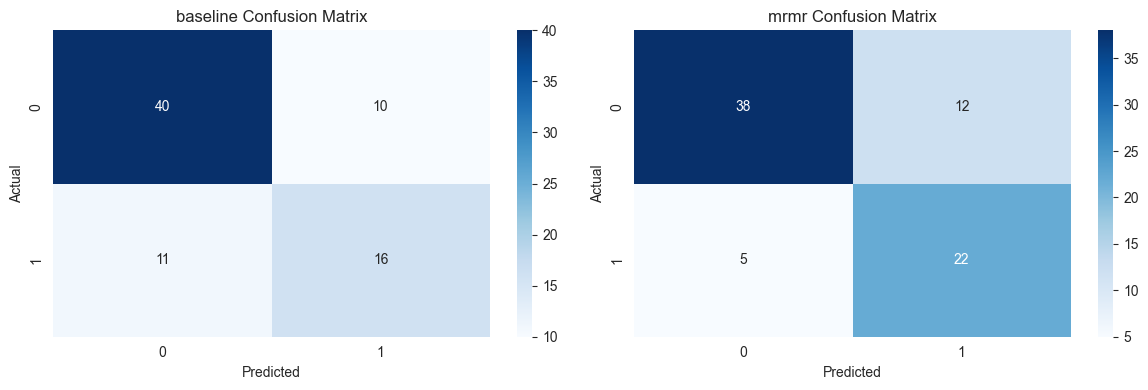

In [15]:
fig, axes = plt.subplots(1, len(SETTINGS), figsize=(12, 4))
if len(SETTINGS) == 1:
    axes = [axes]
for idx, setting in enumerate(SETTINGS.keys()):
    subset = results_df[results_df["setting"] == setting]
    agg = subset[["tn", "fp", "fn", "tp"]].sum()
    cm = np.array([[agg["tn"], agg["fp"]], [agg["fn"], agg["tp"]]])
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f"{setting} Confusion Matrix")
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')
plt.tight_layout()
plt.show()


## ROC Curves


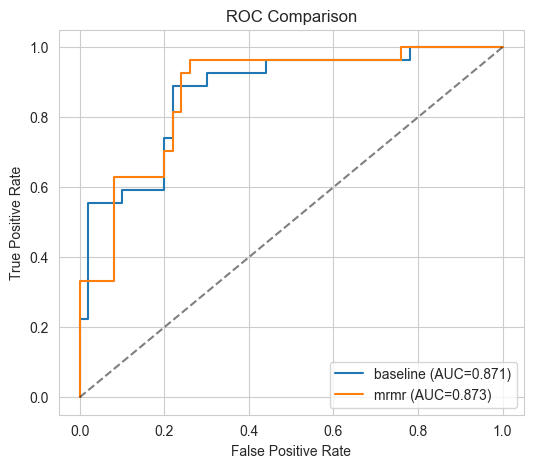

In [16]:
fig, ax = plt.subplots(figsize=(6, 5))
y_true = test_y.to_numpy()
for setting in SETTINGS.keys():
    subset = results_df[results_df["setting"] == setting]
    if subset.empty:
        continue
    proba_matrix = np.array(subset["y_proba"].tolist())
    mean_proba = proba_matrix.mean(axis=0)
    fpr, tpr, _ = roc_curve(y_true, mean_proba)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f"{setting} (AUC={roc_auc:.3f})")
ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Comparison')
ax.legend(loc='lower right')
plt.show()


## 指標箱形圖

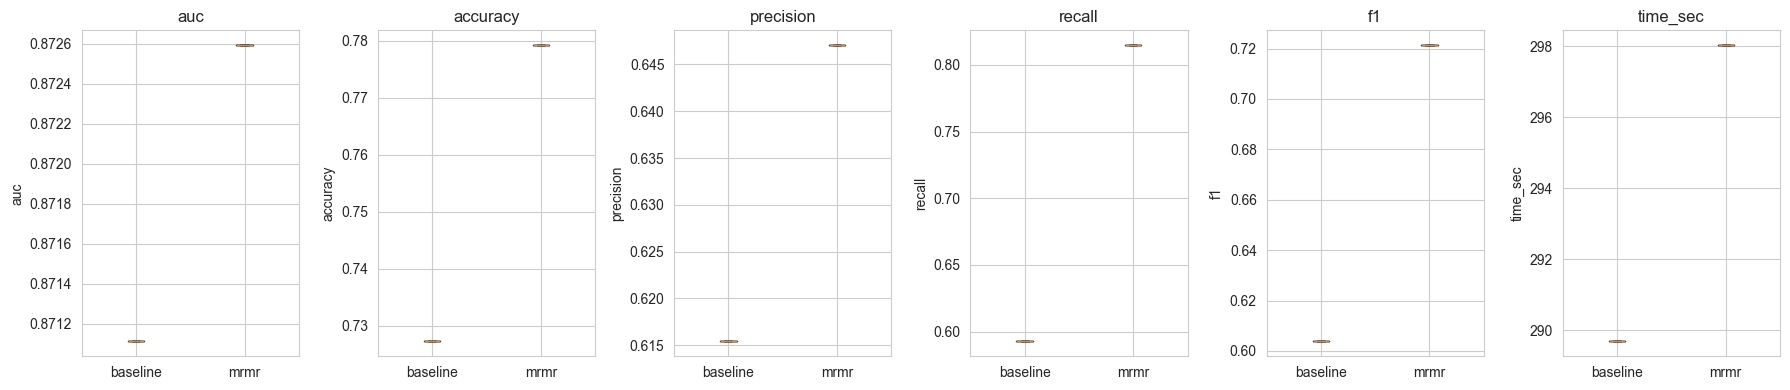

In [17]:
metrics_to_plot = ["auc", "accuracy", "precision", "recall", "f1", "time_sec"]
fig, axes = plt.subplots(1, len(metrics_to_plot), figsize=(18, 4))
for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx]
    grouped = [
        results_df.loc[results_df["setting"] == setting, metric]
        for setting in SETTINGS.keys()
    ]
    ax.boxplot(grouped, labels=list(SETTINGS.keys()))
    ax.set_title(metric)
    ax.set_ylabel(metric)
plt.tight_layout()
plt.show()


## mRMR 在各 fold/seed 的特徵選擇

In [5]:
mrmr_features_df = pd.DataFrame(mrmr_feature_tracking)
print(mrmr_features_df)


NameError: name 'pd' is not defined

## 結論
請根據上述彙總表與圖表說明 mRMR 是否改善 AUC/F1，以及對執行時間的影響。


[快速掃描 k 值] 使用 LogisticRegression + StandardScaler
k=2  AUC=0.7748  features=['Glucose', 'SkinThickness']
k=3  AUC=0.8007  features=['Glucose', 'SkinThickness', 'Pregnancies']
k=4  AUC=0.8081  features=['Glucose', 'SkinThickness', 'Pregnancies', 'BloodPressure']
k=5  AUC=0.8119  features=['Glucose', 'SkinThickness', 'Pregnancies', 'BloodPressure', 'DiabetesPedigreeFunction']
k=6  AUC=0.8422  features=['Glucose', 'SkinThickness', 'Pregnancies', 'BloodPressure', 'DiabetesPedigreeFunction', 'BMI']
k=7  AUC=0.8430  features=['Glucose', 'SkinThickness', 'Pregnancies', 'BloodPressure', 'DiabetesPedigreeFunction', 'BMI', 'Age']
k=8  AUC=0.8415  features=['Glucose', 'SkinThickness', 'Pregnancies', 'BloodPressure', 'DiabetesPedigreeFunction', 'BMI', 'Age', 'Insulin']

掃描結果：


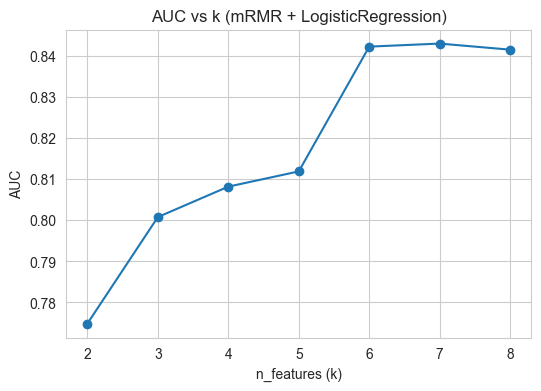

In [19]:
# k-sweep: find a good n_features for mRMR with a simple model
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

k_values = list(range(2, 9))
sweep_results = []

print("\n[快速掃描 k 值] 使用 LogisticRegression + StandardScaler")
for k in k_values:
    mrmr = MRMRSelector(n_features=k, random_state=0)
    mrmr.fit(train_X, train_y)
    feats = mrmr.selected_features_
    clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
    clf.fit(train_X[feats], train_y)
    proba = clf.predict_proba(test_X[feats])[:, 1]
    auc_val = roc_auc_score(test_y, proba)
    sweep_results.append({"k": k, "auc": auc_val, "features": feats})
    print(f"k={k}  AUC={auc_val:.4f}  features={feats}")

sweep_df = pd.DataFrame(sweep_results)
print("\n掃描結果：")
sweep_df

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(sweep_df["k"], sweep_df["auc"], marker="o")
ax.set_xlabel("n_features (k)")
ax.set_ylabel("AUC")
ax.set_title("AUC vs k (mRMR + LogisticRegression)")
plt.show()
